The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_x_only_wind"
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_z_only_wind"
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_xz_wind"
training_subfolder = "wind_near_wall_wo_bemt_in_control_far_from_wall"  # training in no wall condition
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
# validation_subfolder = "wind_near_wall_validation_no_bemt"
validation_subfolder = "wind_near_wall_validation_no_bemt_sinusoidal"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn3_0_y0_0_zn5_0_d100_4_fitting.csv

Validation Data List:
wind_near_wall_validation_no_bemt_sinusoidal\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt_sinusoidal\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt_sinusoidal\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_wo_bemt_in_control_far_from_wall\normalization_params.yaml
Using 1501 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_far_from_wall\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting

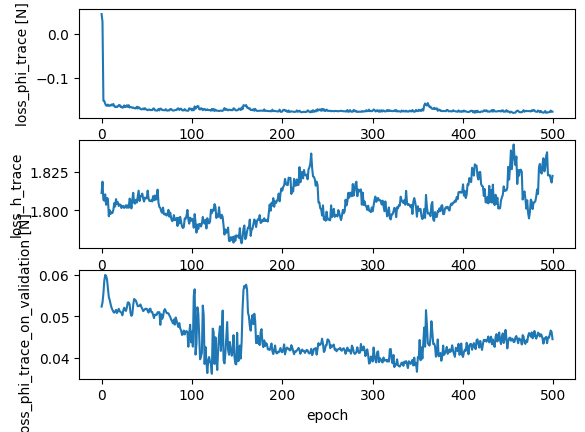

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(True)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
plt.show() 
manager.train()

plt.show()  

Inspect data in the data list.

Plotting t-SNE of a_trace...


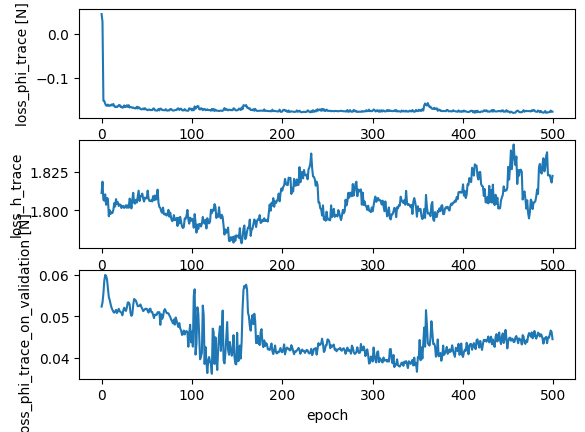

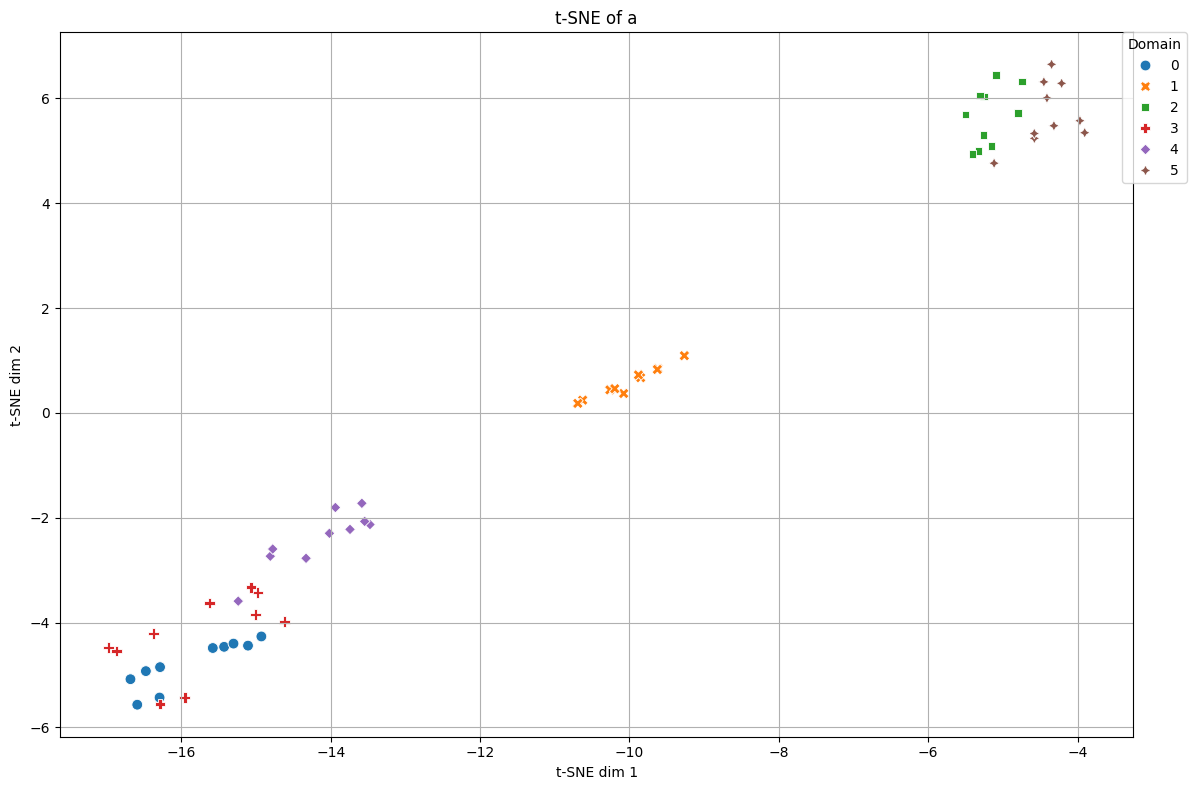

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_wo_bemt_in_control_far_from_wall.pth


Test the model using the test set.

test Data List:
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wi

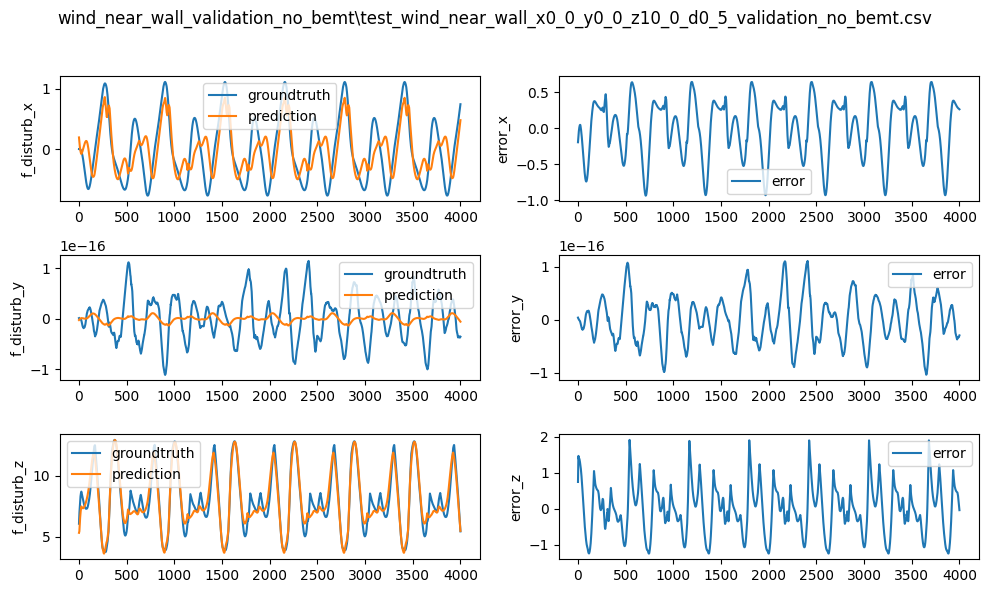

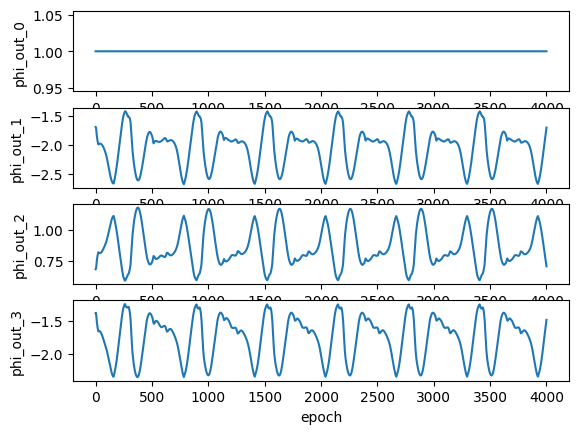

phi_out: tensor([[ 1.0000, -1.6968,  0.6856, -1.3836],
        [ 1.0000, -1.6973,  0.6859, -1.3828],
        [ 1.0000, -1.6979,  0.6861, -1.3821],
        ...,
        [ 1.0000, -1.5762,  0.6415, -1.3610],
        [ 1.0000, -1.5730,  0.6409, -1.3578],
        [ 1.0000, -1.5699,  0.6403, -1.3544]])
a = tensor([[ 7.0178e-01, -7.1733e-19, -3.8324e+00],
        [ 2.8965e+00, -1.1693e-17,  2.8792e+00],
        [ 5.5636e+00, -2.2292e-17,  6.8750e+00],
        [-2.6556e-01,  2.6908e-18, -3.2589e+00]])


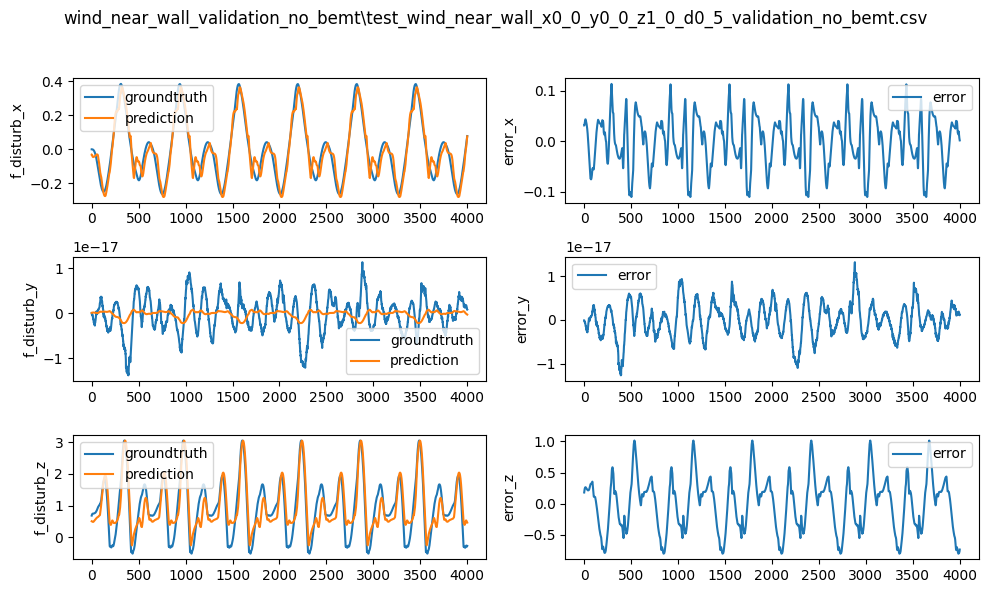

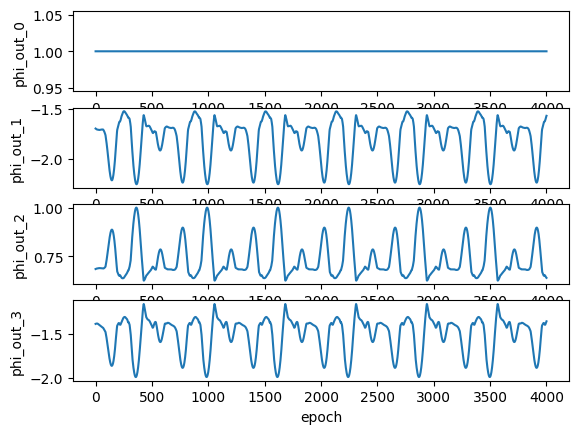

phi_out: tensor([[ 1.0000, -1.6969,  0.6856, -1.3838],
        [ 1.0000, -1.6976,  0.6861, -1.3826],
        [ 1.0000, -1.6991,  0.6866, -1.3819],
        ...,
        [ 1.0000, -1.5600,  0.6342, -1.3557],
        [ 1.0000, -1.5557,  0.6332, -1.3521],
        [ 1.0000, -1.5516,  0.6323, -1.3484]])
a = tensor([[ 1.0576e+00,  3.1476e-18, -3.1828e+00],
        [ 3.5394e+00,  4.0195e-18,  1.4462e+00],
        [ 4.8833e+00, -1.1701e-17, -1.8266e-01],
        [-1.1410e+00, -8.6129e-18, -5.9558e+00]])


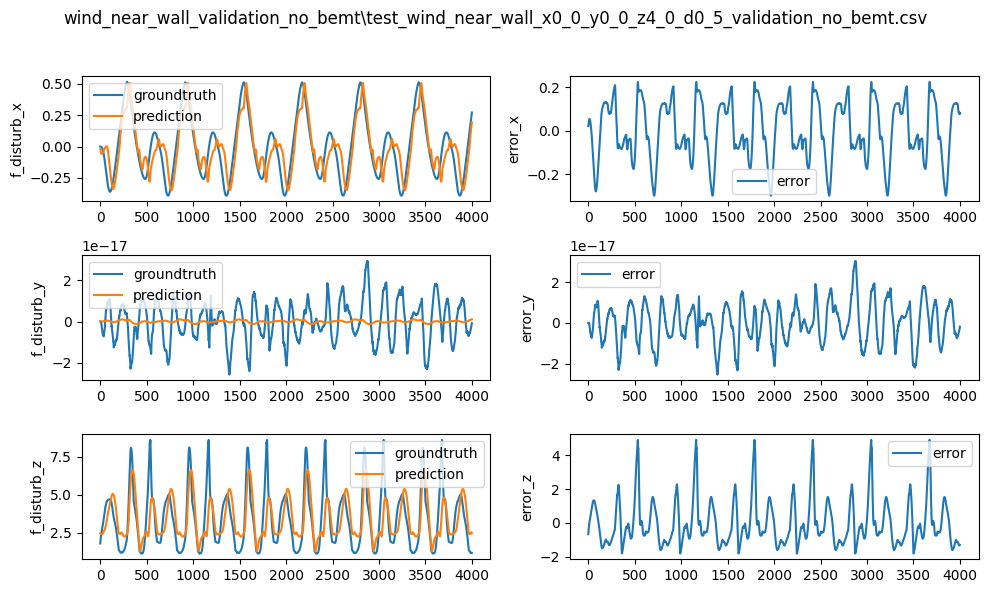

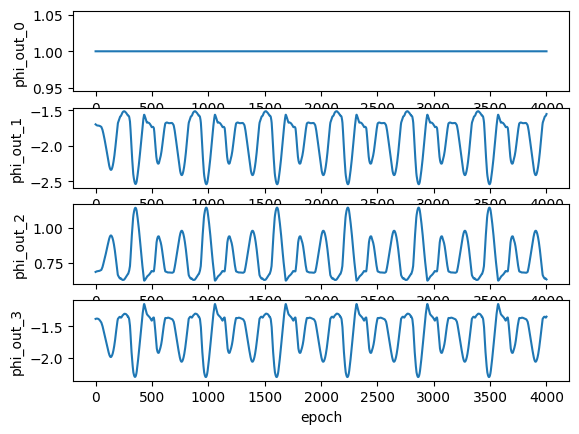

phi_out: tensor([[ 1.0000, -1.6970,  0.6857, -1.3841],
        [ 1.0000, -1.6983,  0.6864, -1.3824],
        [ 1.0000, -1.7006,  0.6872, -1.3818],
        ...,
        [ 1.0000, -1.5924,  0.6466, -1.3626],
        [ 1.0000, -1.5909,  0.6469, -1.3643],
        [ 1.0000, -1.5894,  0.6472, -1.3661]])
a = tensor([[-8.8894e-02, -4.1804e-17, -3.0636e-03],
        [ 3.5456e+00, -4.3091e-17, -6.1088e+00],
        [ 1.6211e+01,  8.6048e-17,  2.9595e-01],
        [ 3.7209e+00,  6.6734e-17,  5.5671e+00]])


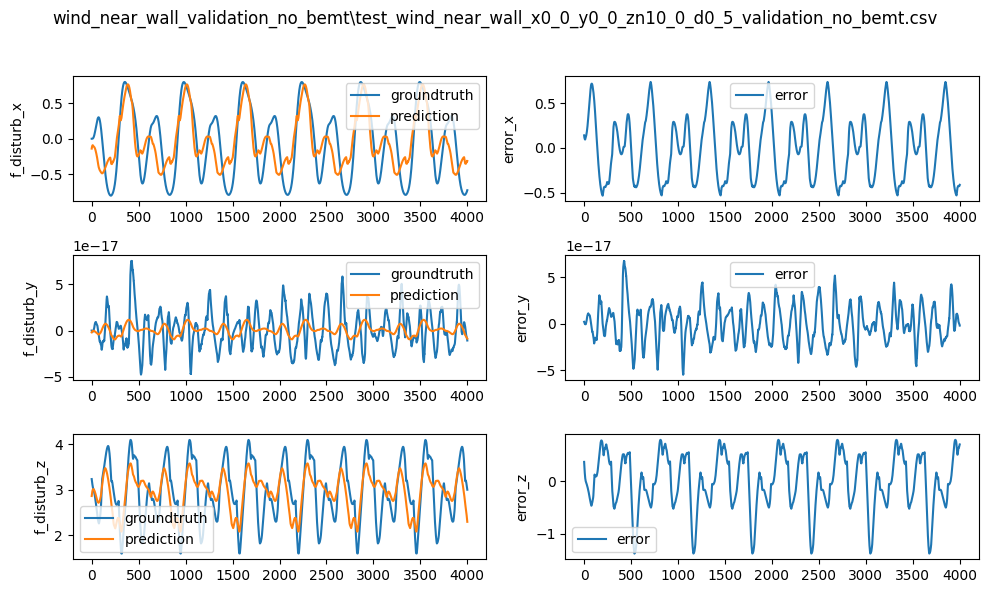

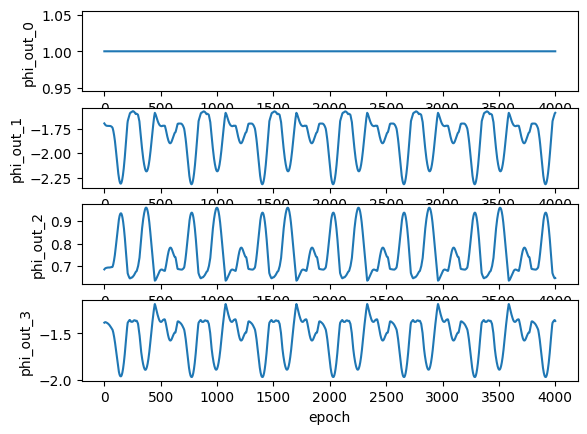

phi_out: tensor([[ 1.0000, -1.6967,  0.6855, -1.3833],
        [ 1.0000, -1.6969,  0.6856, -1.3831],
        [ 1.0000, -1.6973,  0.6857, -1.3828],
        ...,
        [ 1.0000, -1.5854,  0.6452, -1.3684],
        [ 1.0000, -1.5823,  0.6445, -1.3652],
        [ 1.0000, -1.5792,  0.6439, -1.3618]])
a = tensor([[ 4.5208e-01,  2.8463e-18, -2.5026e+00],
        [ 2.5038e+00,  6.6575e-18,  4.6696e+00],
        [ 6.3762e+00, -2.3400e-17,  9.2794e+00],
        [ 4.3963e-01, -1.7532e-17, -2.6497e+00]])


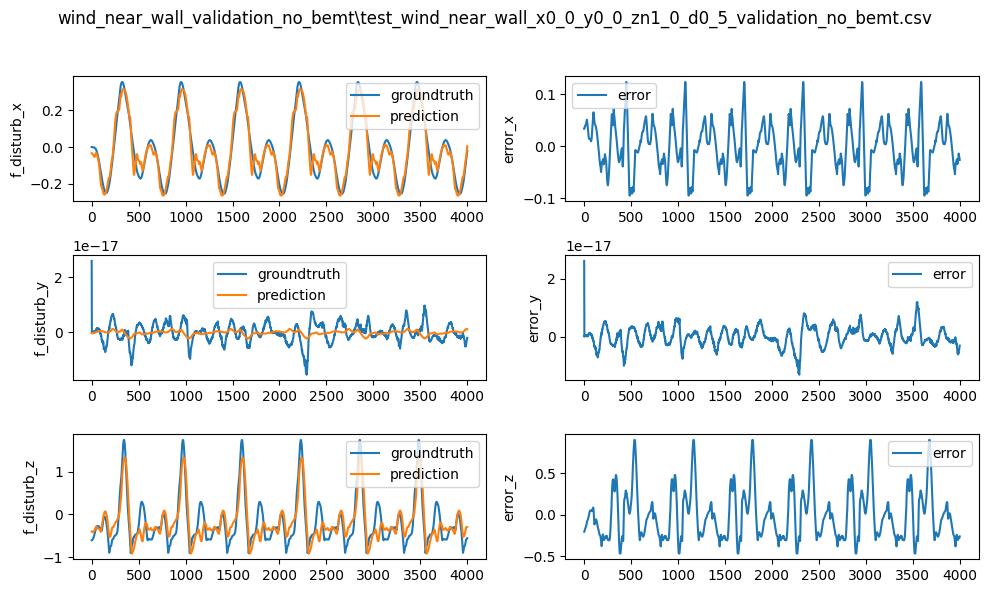

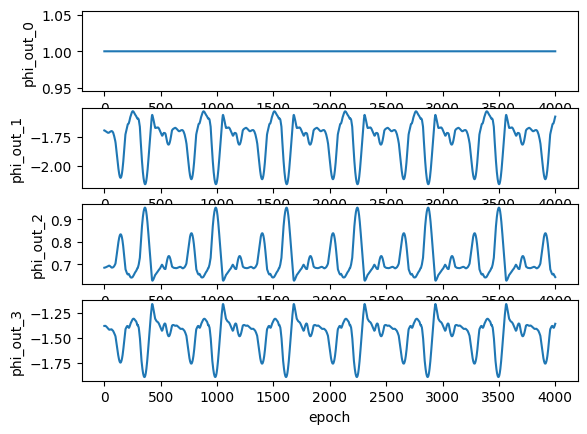

phi_out: tensor([[ 1.0000, -1.6967,  0.6855, -1.3834],
        [ 1.0000, -1.6969,  0.6856, -1.3831],
        [ 1.0000, -1.6974,  0.6858, -1.3827],
        ...,
        [ 1.0000, -1.5982,  0.6498, -1.3840],
        [ 1.0000, -1.5944,  0.6489, -1.3805],
        [ 1.0000, -1.5907,  0.6481, -1.3770]])
a = tensor([[ 1.5118e-01, -7.5462e-19, -5.8405e-01],
        [ 2.6135e+00, -4.9031e-18, -7.9223e-01],
        [ 9.6933e+00, -1.3800e-17,  2.2027e+00],
        [ 1.7406e+00, -1.3486e-18,  1.8272e+00]])


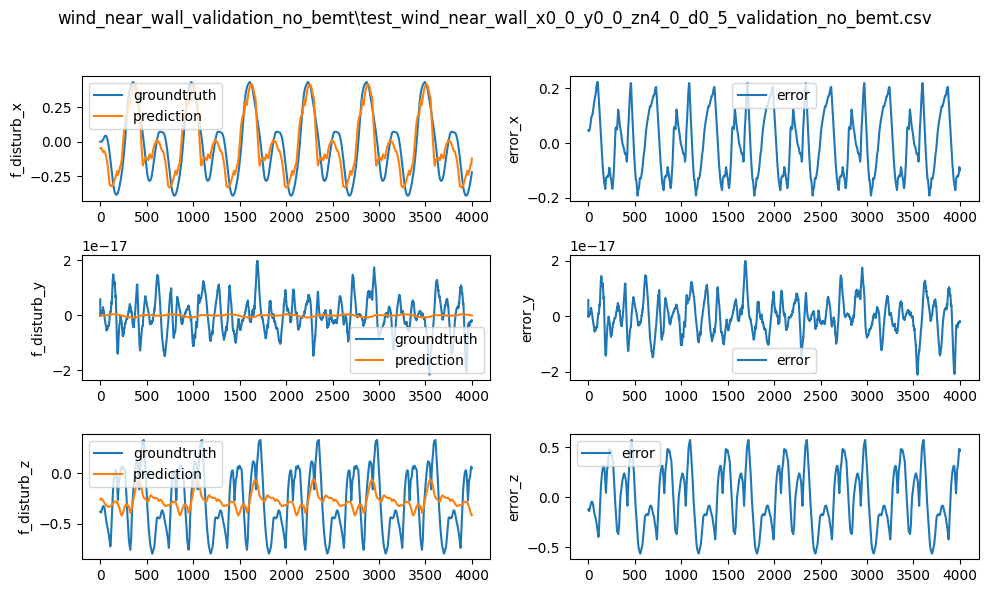

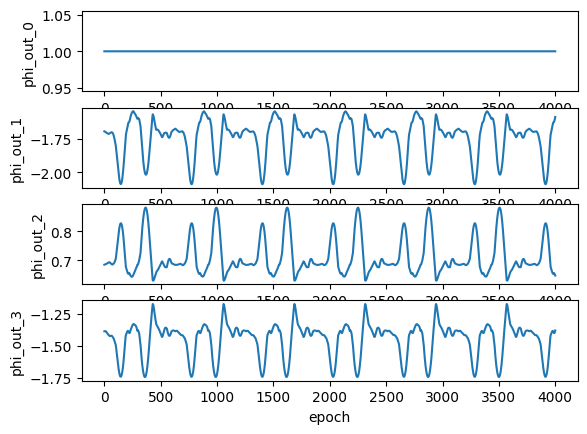

phi_out: tensor([[ 1.0000, -1.6972,  0.6858, -1.3845],
        [ 1.0000, -1.7007,  0.6872, -1.3821],
        [ 1.0000, -1.7049,  0.6884, -1.3808],
        ...,
        [ 1.0000, -1.7437,  0.7241, -1.5144],
        [ 1.0000, -1.7305,  0.7188, -1.5028],
        [ 1.0000, -1.7174,  0.7135, -1.4913]])
a = tensor([[ 1.8851e+00, -2.8482e-16, -5.1016e+00],
        [ 4.0064e+00,  1.1008e-16, -4.8914e-02],
        [ 1.6478e+00,  2.0993e-16,  1.7041e+01],
        [-2.6994e+00, -1.7506e-16,  9.7015e-01]])


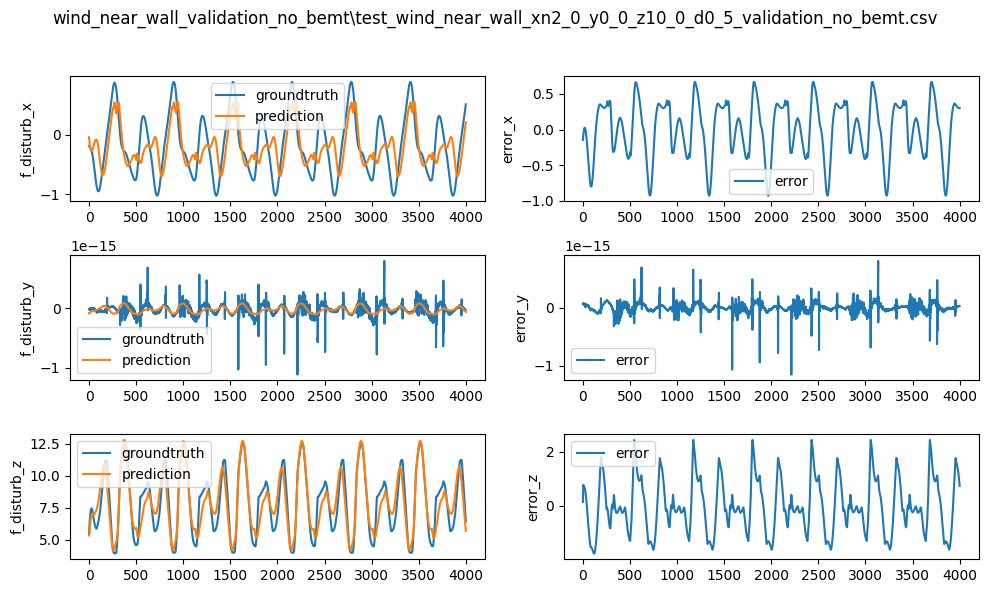

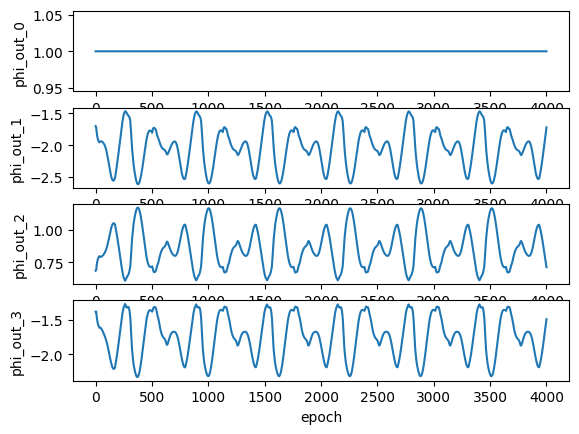

phi_out: tensor([[ 1.0000, -1.6968,  0.6856, -1.3836],
        [ 1.0000, -1.6980,  0.6860, -1.3824],
        [ 1.0000, -1.6990,  0.6864, -1.3813],
        ...,
        [ 1.0000, -1.5861,  0.6447, -1.3730],
        [ 1.0000, -1.5820,  0.6438, -1.3693],
        [ 1.0000, -1.5780,  0.6429, -1.3656]])
a = tensor([[ 6.8797e-01, -9.6747e-18, -3.7780e+00],
        [ 2.9690e+00, -1.3132e-18,  1.7326e+00],
        [ 7.2563e+00,  2.1271e-16,  4.6707e-01],
        [ 5.7707e-01,  1.0740e-16, -5.0992e+00]])


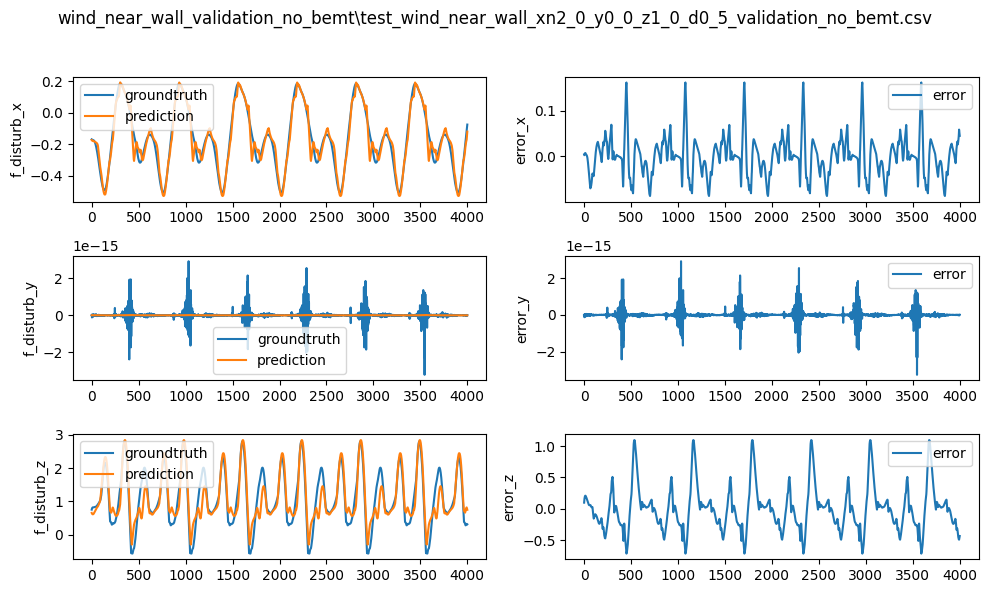

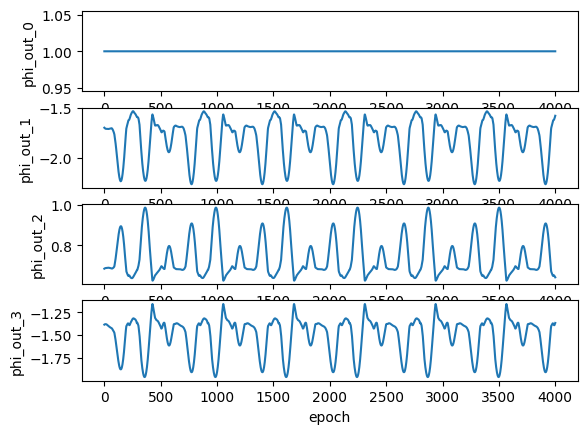

phi_out: tensor([[ 1.0000, -1.6970,  0.6857, -1.3840],
        [ 1.0000, -1.6987,  0.6865, -1.3821],
        [ 1.0000, -1.7012,  0.6872, -1.3812],
        ...,
        [ 1.0000, -1.5775,  0.6402, -1.3672],
        [ 1.0000, -1.5746,  0.6394, -1.3661],
        [ 1.0000, -1.5701,  0.6385, -1.3637]])
a = tensor([[ 9.5538e-01, -8.4821e-18, -1.8245e+00],
        [ 3.7209e+00,  2.1976e-17,  4.6366e+00],
        [ 6.5087e+00, -1.0611e-16,  5.6751e+00],
        [-5.1173e-01, -7.2122e-17, -6.0281e+00]])


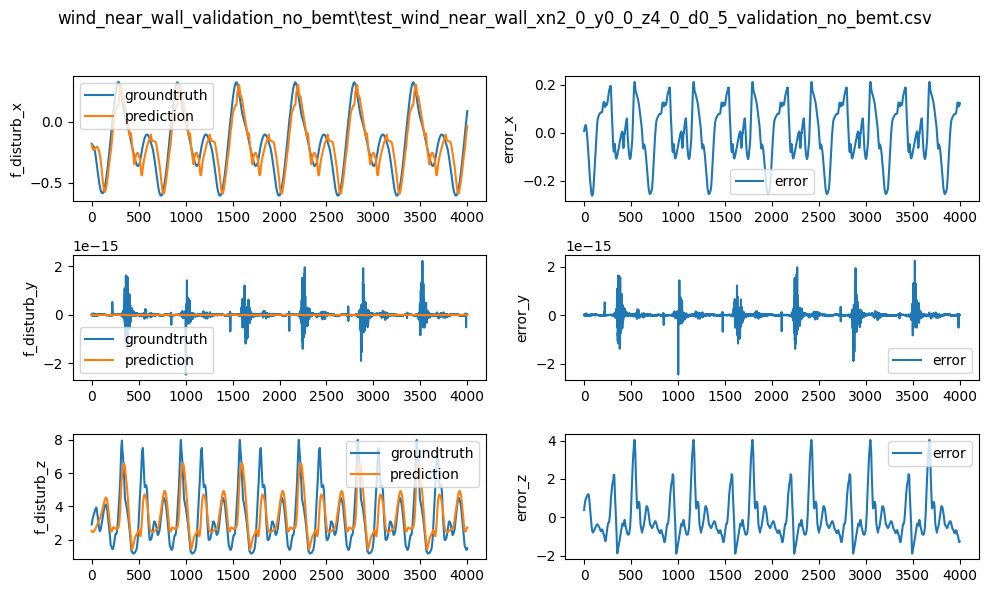

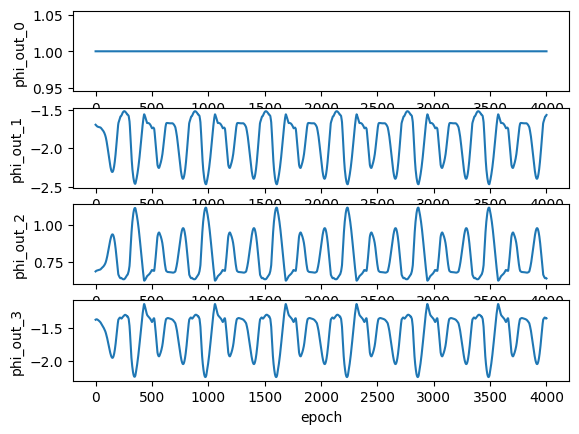

phi_out: tensor([[ 1.0000, -1.6970,  0.6857, -1.3840],
        [ 1.0000, -1.6992,  0.6865, -1.3818],
        [ 1.0000, -1.7021,  0.6874, -1.3807],
        ...,
        [ 1.0000, -1.6082,  0.6539, -1.3801],
        [ 1.0000, -1.6069,  0.6542, -1.3818],
        [ 1.0000, -1.6068,  0.6548, -1.3836]])
a = tensor([[-2.4431e-01,  2.3630e-17, -3.0466e-01],
        [ 3.7621e+00,  6.3409e-17, -6.5377e+00],
        [ 1.8773e+01,  2.3139e-17,  3.0803e+00],
        [ 4.7768e+00, -3.7176e-17,  7.2939e+00]])


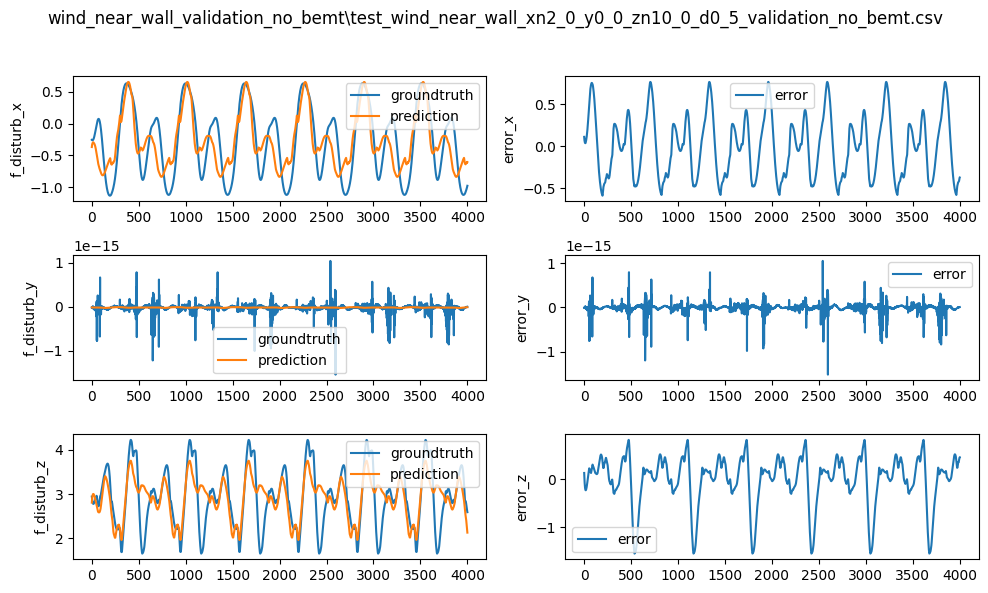

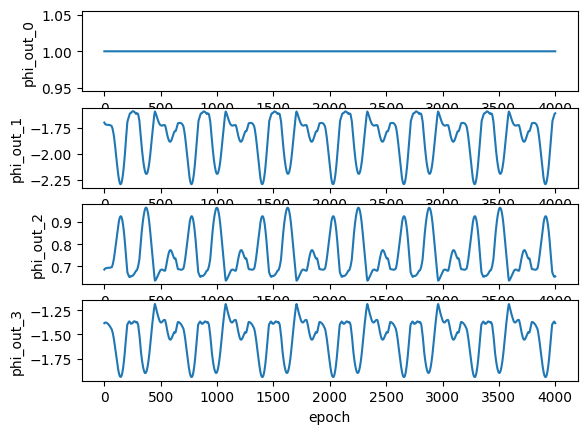

phi_out: tensor([[ 1.0000, -1.6966,  0.6855, -1.3833],
        [ 1.0000, -1.6976,  0.6857, -1.3827],
        [ 1.0000, -1.6984,  0.6859, -1.3821],
        ...,
        [ 1.0000, -1.5928,  0.6482, -1.3745],
        [ 1.0000, -1.5897,  0.6476, -1.3715],
        [ 1.0000, -1.5866,  0.6469, -1.3682]])
a = tensor([[ 3.7352e-01,  1.4458e-17, -3.0914e+00],
        [ 2.4983e+00,  7.8339e-18,  2.1862e+00],
        [ 7.8496e+00,  5.1442e-17,  4.9934e+00],
        [ 1.2204e+00,  3.5205e-17, -2.2289e+00]])


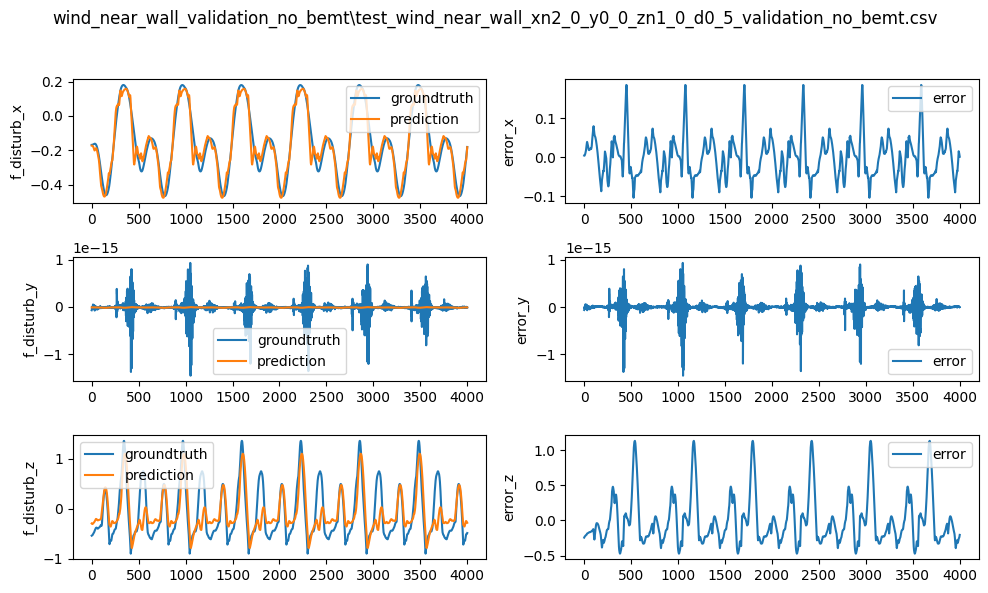

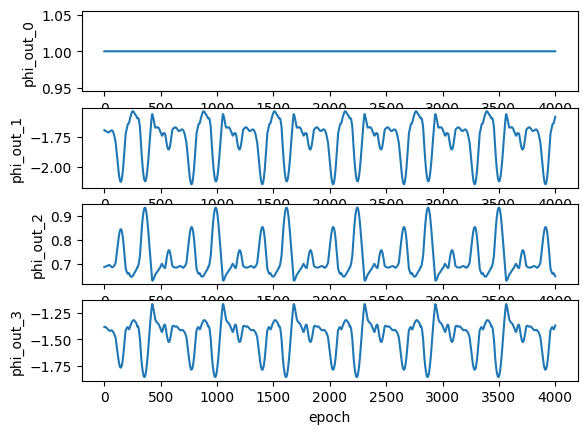

phi_out: tensor([[ 1.0000, -1.6966,  0.6855, -1.3834],
        [ 1.0000, -1.6978,  0.6858, -1.3825],
        [ 1.0000, -1.6987,  0.6860, -1.3818],
        ...,
        [ 1.0000, -1.6059,  0.6532, -1.3886],
        [ 1.0000, -1.6023,  0.6524, -1.3852],
        [ 1.0000, -1.5993,  0.6519, -1.3825]])
a = tensor([[ 8.4832e-02,  1.1044e-17, -1.0969e+00],
        [ 2.6895e+00,  2.7388e-17, -1.7817e+00],
        [ 1.1679e+01, -5.0625e-17,  3.4544e+00],
        [ 2.7060e+00, -3.8917e-17,  3.3135e+00]])


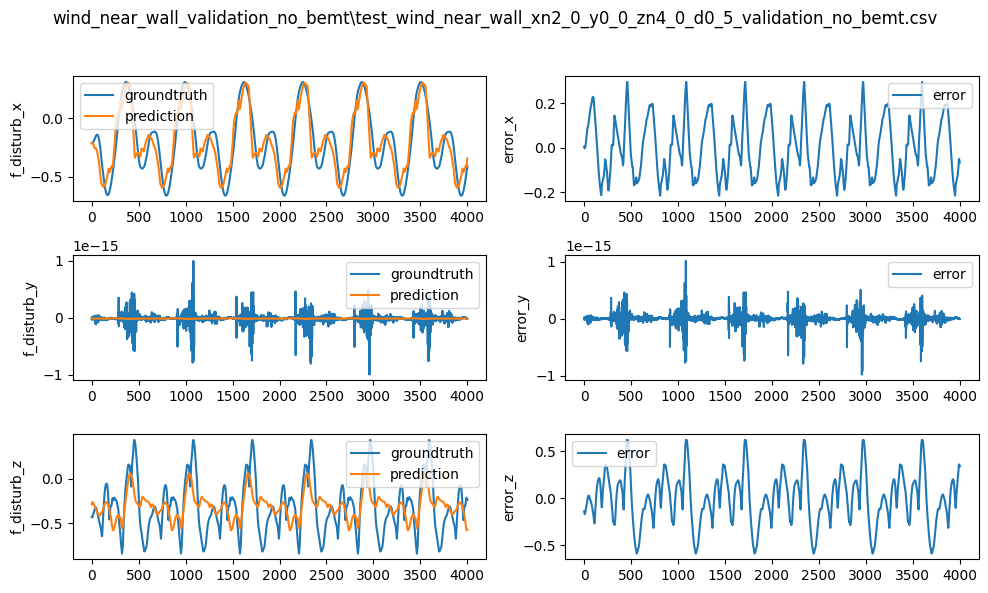

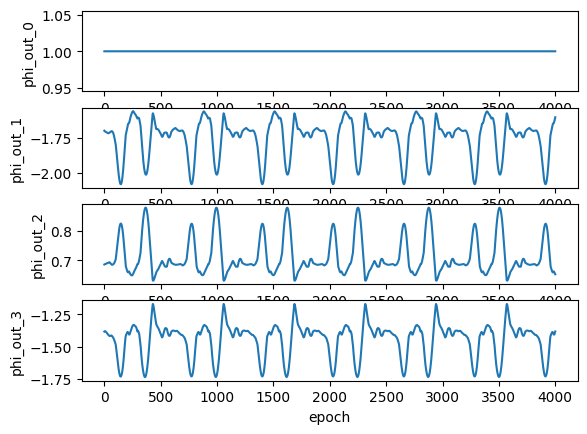

phi_out: tensor([[ 1.0000, -1.6971,  0.6858, -1.3844],
        [ 1.0000, -1.7016,  0.6872, -1.3813],
        [ 1.0000, -1.7063,  0.6885, -1.3795],
        ...,
        [ 1.0000, -1.7093,  0.7095, -1.4707],
        [ 1.0000, -1.6978,  0.7048, -1.4606],
        [ 1.0000, -1.6863,  0.7002, -1.4506]])
a = tensor([[ 1.3095e+00, -3.7887e-16, -1.7484e+00],
        [ 4.5186e+00,  4.3987e-17,  4.1560e+00],
        [ 6.6202e+00, -2.8590e-16,  2.0711e+01],
        [-1.0082e+00, -3.7854e-16, -1.5786e-01]])


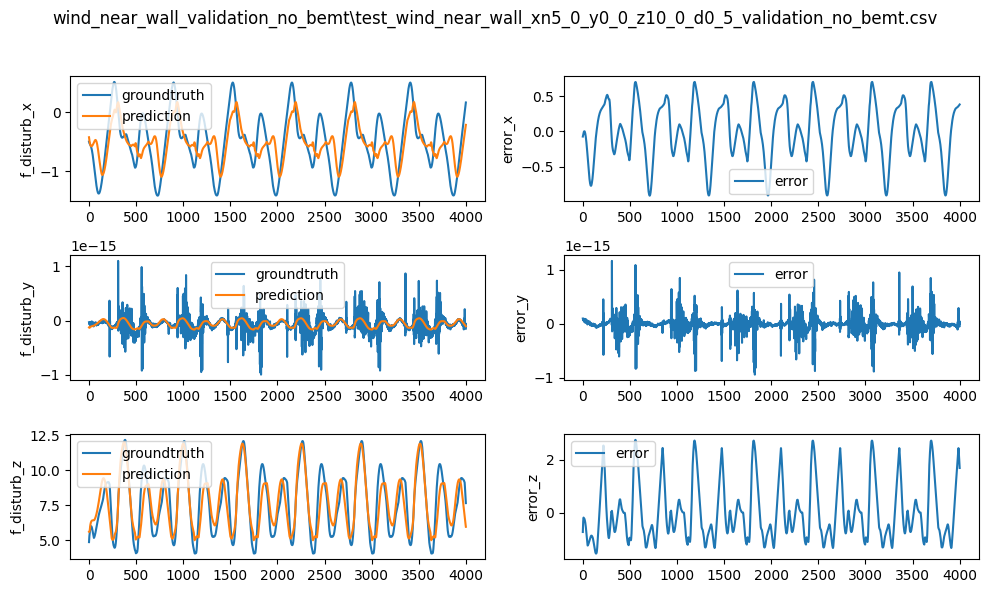

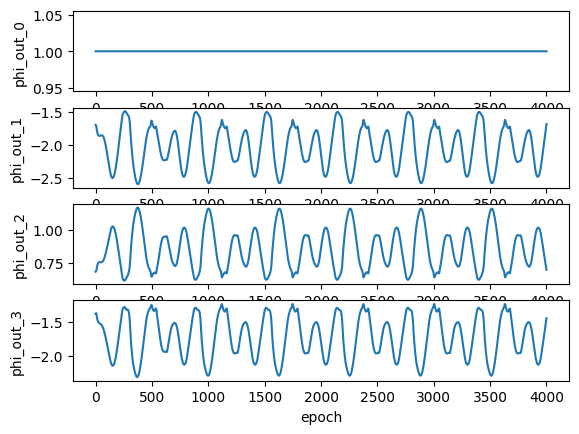

phi_out: tensor([[ 1.0000, -1.6968,  0.6856, -1.3837],
        [ 1.0000, -1.6991,  0.6862, -1.3816],
        [ 1.0000, -1.7011,  0.6868, -1.3801],
        ...,
        [ 1.0000, -1.6032,  0.6505, -1.3856],
        [ 1.0000, -1.6014,  0.6501, -1.3857],
        [ 1.0000, -1.5977,  0.6494, -1.3841]])
a = tensor([[ 6.8840e-01,  7.1128e-17, -3.6898e+00],
        [ 3.1644e+00, -2.3719e-16,  3.6698e-01],
        [ 1.0129e+01, -8.4681e-16, -8.6163e+00],
        [ 1.9244e+00, -5.5328e-17, -8.0779e+00]])


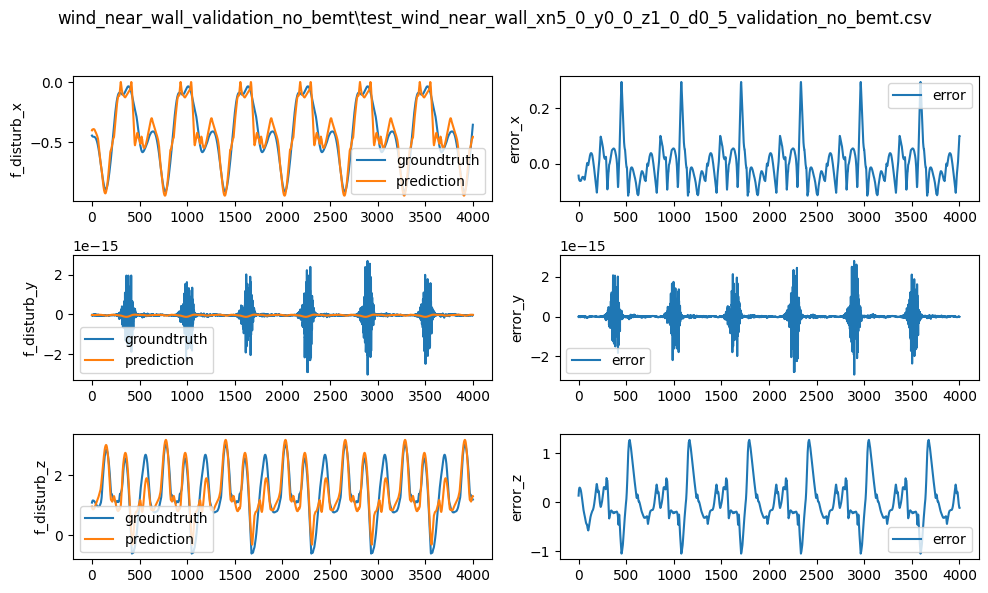

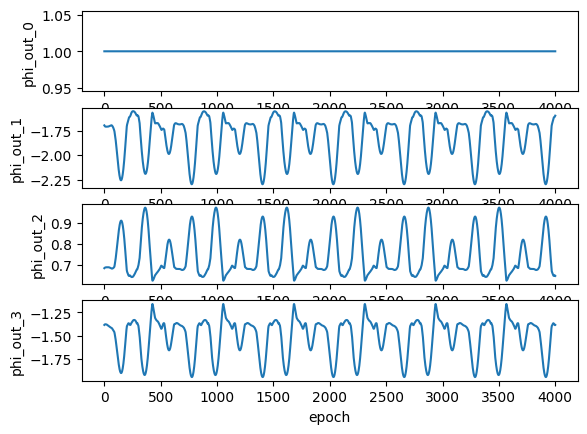

phi_out: tensor([[ 1.0000, -1.6969,  0.6857, -1.3840],
        [ 1.0000, -1.7003,  0.6867, -1.3810],
        [ 1.0000, -1.7040,  0.6876, -1.3794],
        ...,
        [ 1.0000, -1.5675,  0.6358, -1.3406],
        [ 1.0000, -1.5650,  0.6355, -1.3412],
        [ 1.0000, -1.5622,  0.6352, -1.3415]])
a = tensor([[ 9.2516e-01, -1.0491e-17,  1.4626e+00],
        [ 4.0297e+00,  3.9885e-17,  1.1109e+01],
        [ 9.5160e+00, -2.4544e-17, -7.3577e-01],
        [ 7.5500e-01, -3.8725e-17, -1.5107e+01]])


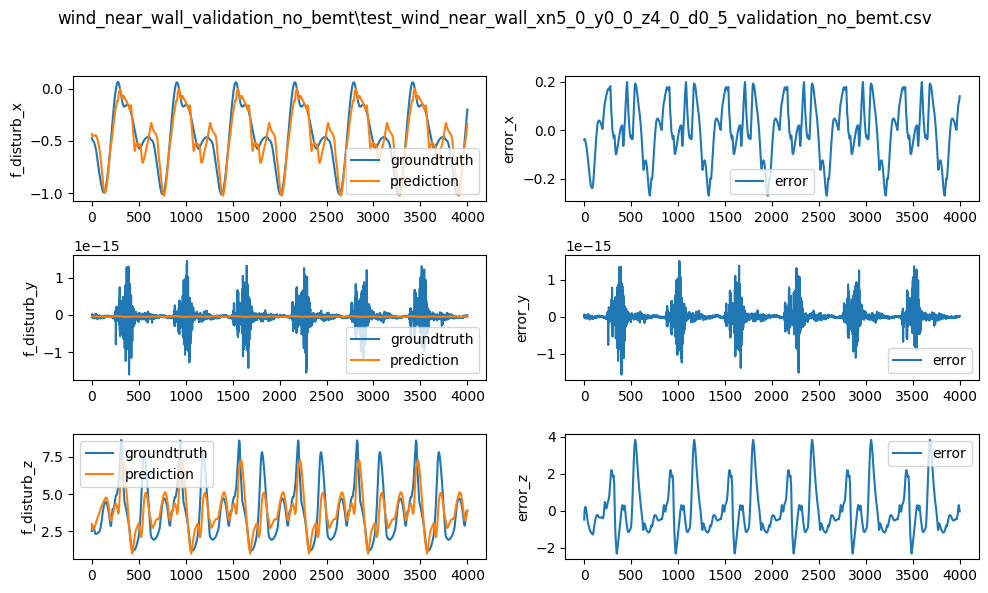

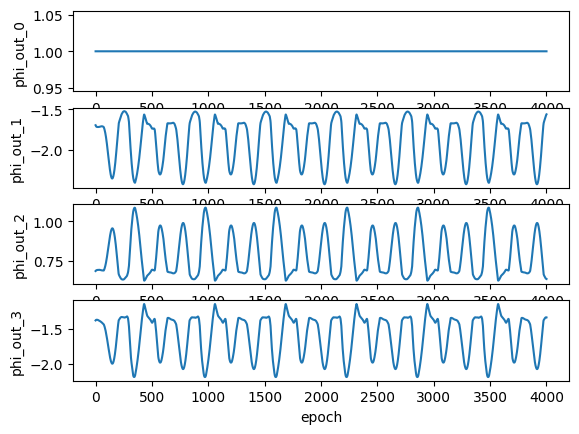

phi_out: tensor([[ 1.0000, -1.6969,  0.6857, -1.3840],
        [ 1.0000, -1.7007,  0.6868, -1.3808],
        [ 1.0000, -1.7045,  0.6877, -1.3791],
        ...,
        [ 1.0000, -1.6363,  0.6657, -1.4082],
        [ 1.0000, -1.6351,  0.6654, -1.4086],
        [ 1.0000, -1.6339,  0.6651, -1.4090]])
a = tensor([[-3.9241e-01,  2.2814e-17, -1.9240e+00],
        [ 4.1086e+00,  9.2170e-17, -7.3900e+00],
        [ 2.2292e+01,  4.2602e-17,  9.7666e+00],
        [ 6.2228e+00, -4.0720e-17,  1.0678e+01]])


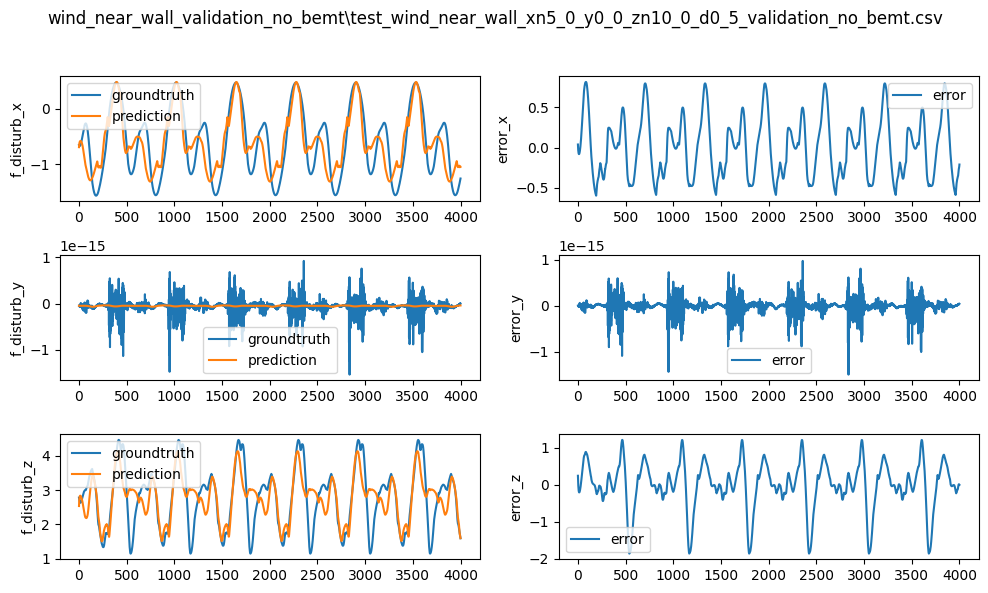

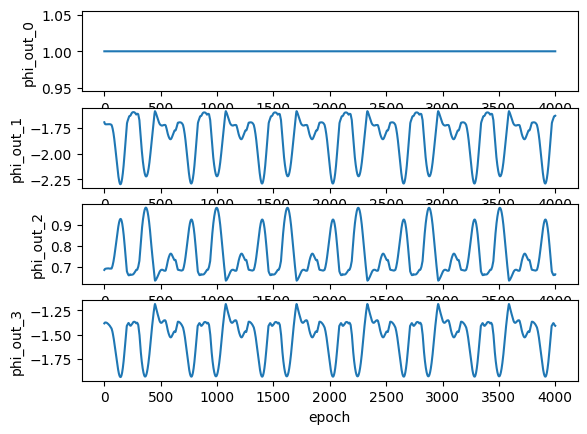

phi_out: tensor([[ 1.0000, -1.6967,  0.6855, -1.3834],
        [ 1.0000, -1.6985,  0.6859, -1.3820],
        [ 1.0000, -1.7000,  0.6863, -1.3809],
        ...,
        [ 1.0000, -1.6082,  0.6533, -1.3920],
        [ 1.0000, -1.6041,  0.6524, -1.3896],
        [ 1.0000, -1.6002,  0.6515, -1.3863]])
a = tensor([[ 4.8278e-01,  3.1254e-17, -2.8885e+00],
        [ 2.7612e+00,  8.6165e-18,  2.1008e-01],
        [ 1.0263e+01,  9.2327e-18, -6.4730e+00],
        [ 2.3227e+00,  4.1565e-17, -5.6254e+00]])


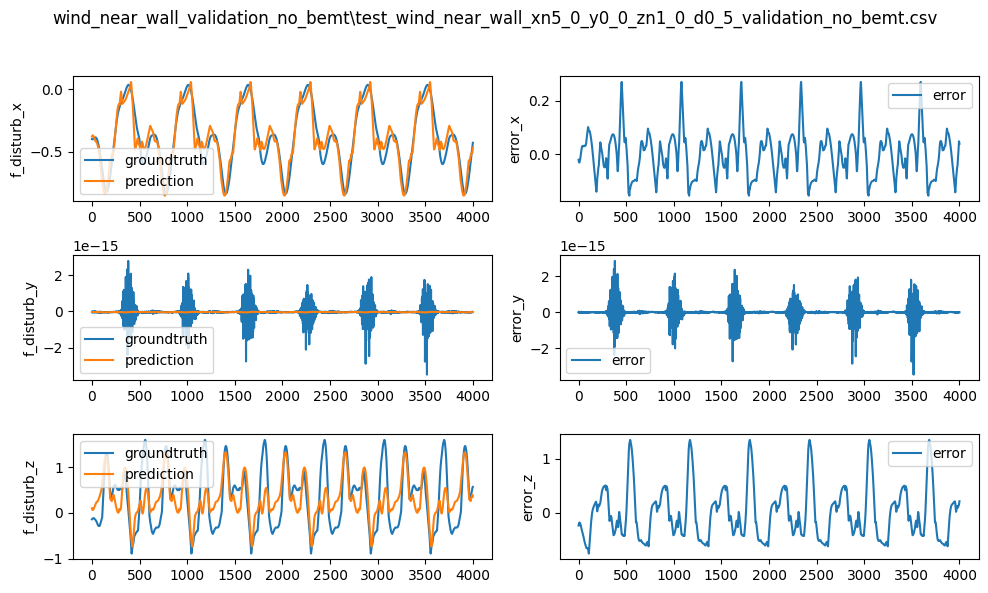

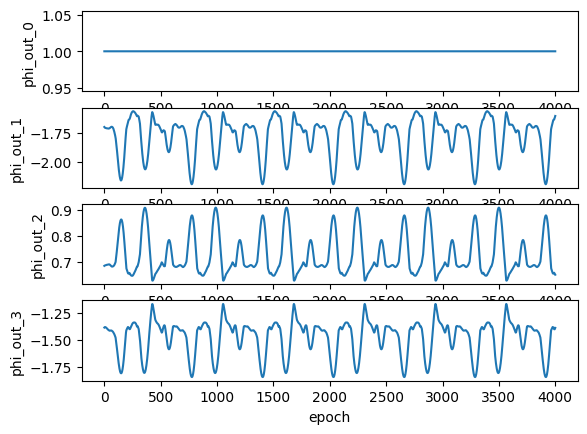

phi_out: tensor([[ 1.0000, -1.6966,  0.6855, -1.3834],
        [ 1.0000, -1.6991,  0.6860, -1.3817],
        [ 1.0000, -1.7009,  0.6863, -1.3804],
        ...,
        [ 1.0000, -1.6145,  0.6572, -1.3952],
        [ 1.0000, -1.6115,  0.6566, -1.3924],
        [ 1.0000, -1.6086,  0.6561, -1.3897]])
a = tensor([[ 4.0593e-02, -1.6709e-16, -1.2656e+00],
        [ 2.7504e+00,  2.6380e-16, -2.7215e+00],
        [ 1.3788e+01,  4.3295e-16,  3.9553e+00],
        [ 3.8124e+00, -1.9529e-16,  4.5514e+00]])


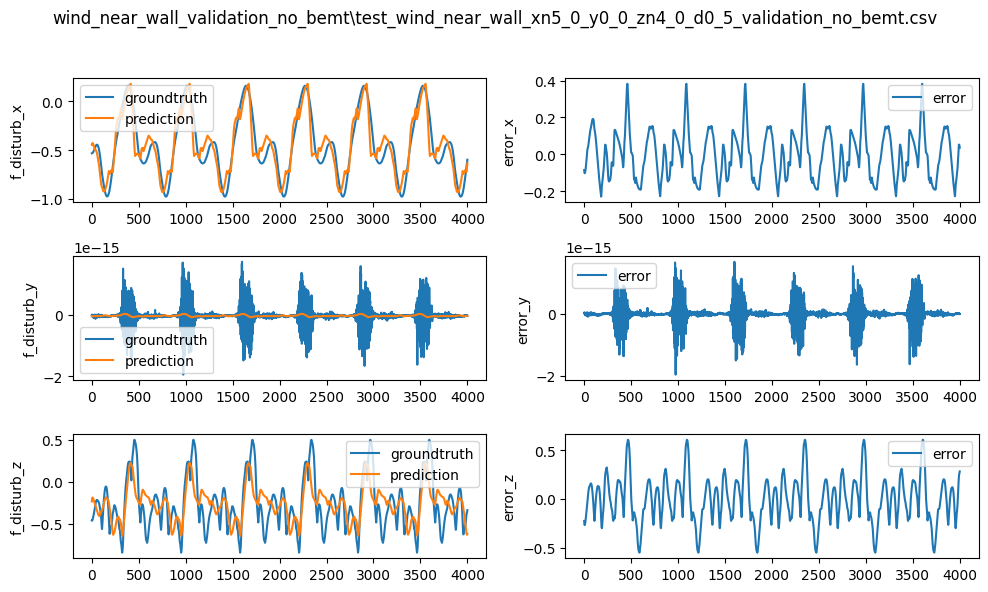

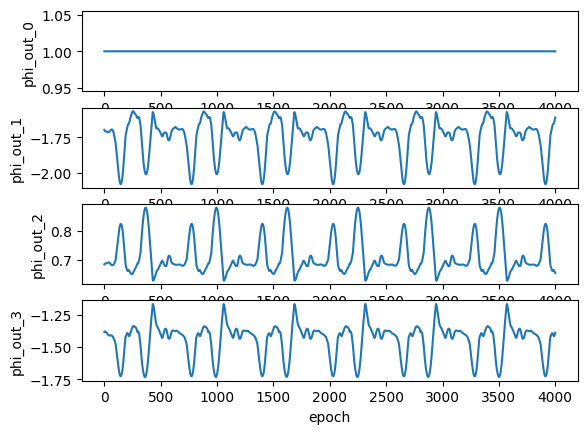

average rms for dim 0: 0.18678545126033042
average rms for dim 1: 1.3530374108471638e-16
average rms for dim 2: 0.6359914239690936


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


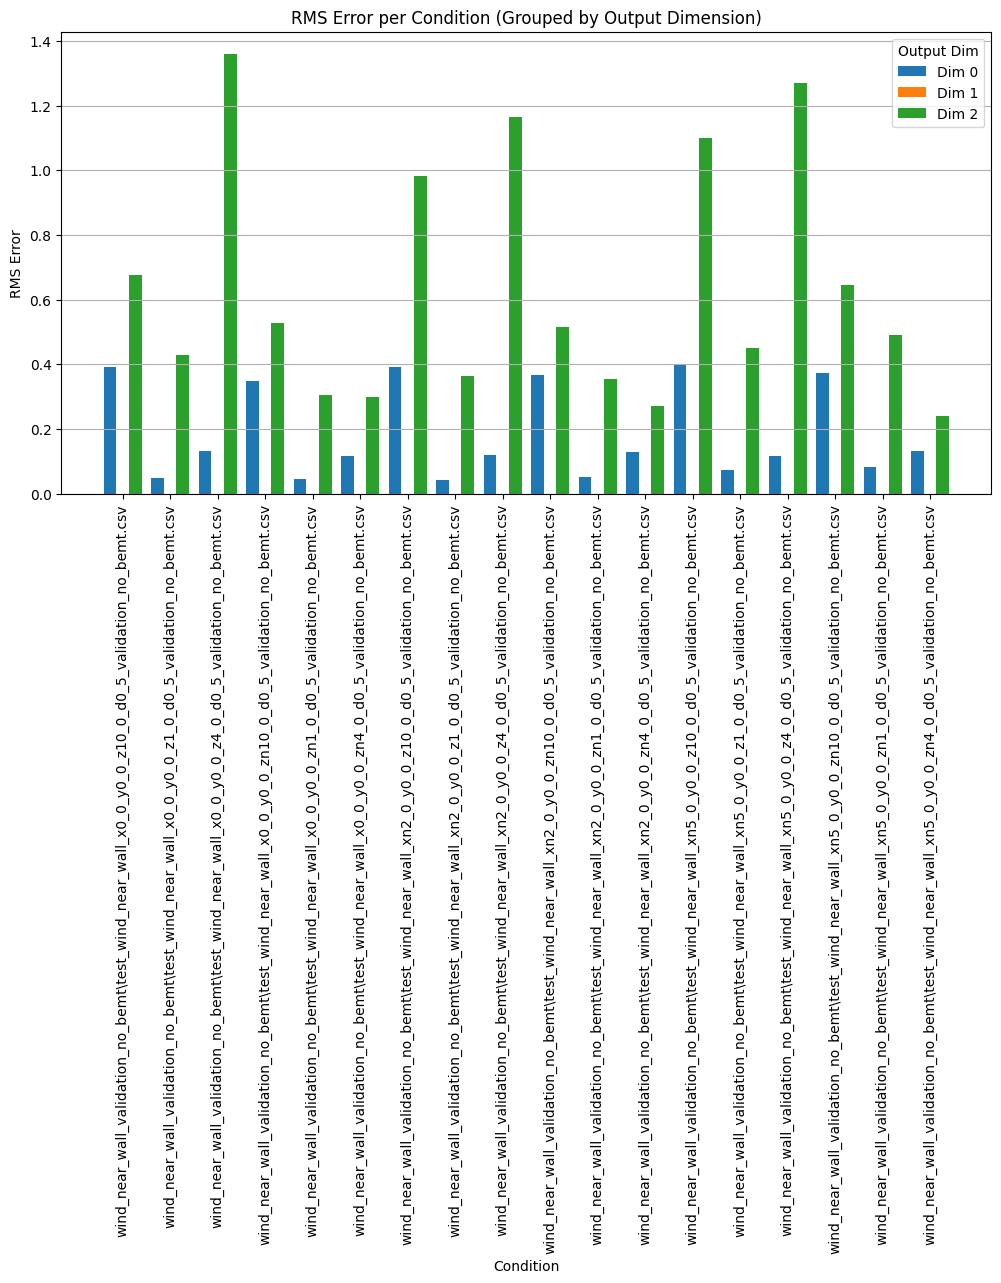

average mse for dim 0: 0.054167072983571596
average mse for dim 1: 3.1427254015944877e-32
average mse for dim 2: 0.5342783749229535


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:196: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


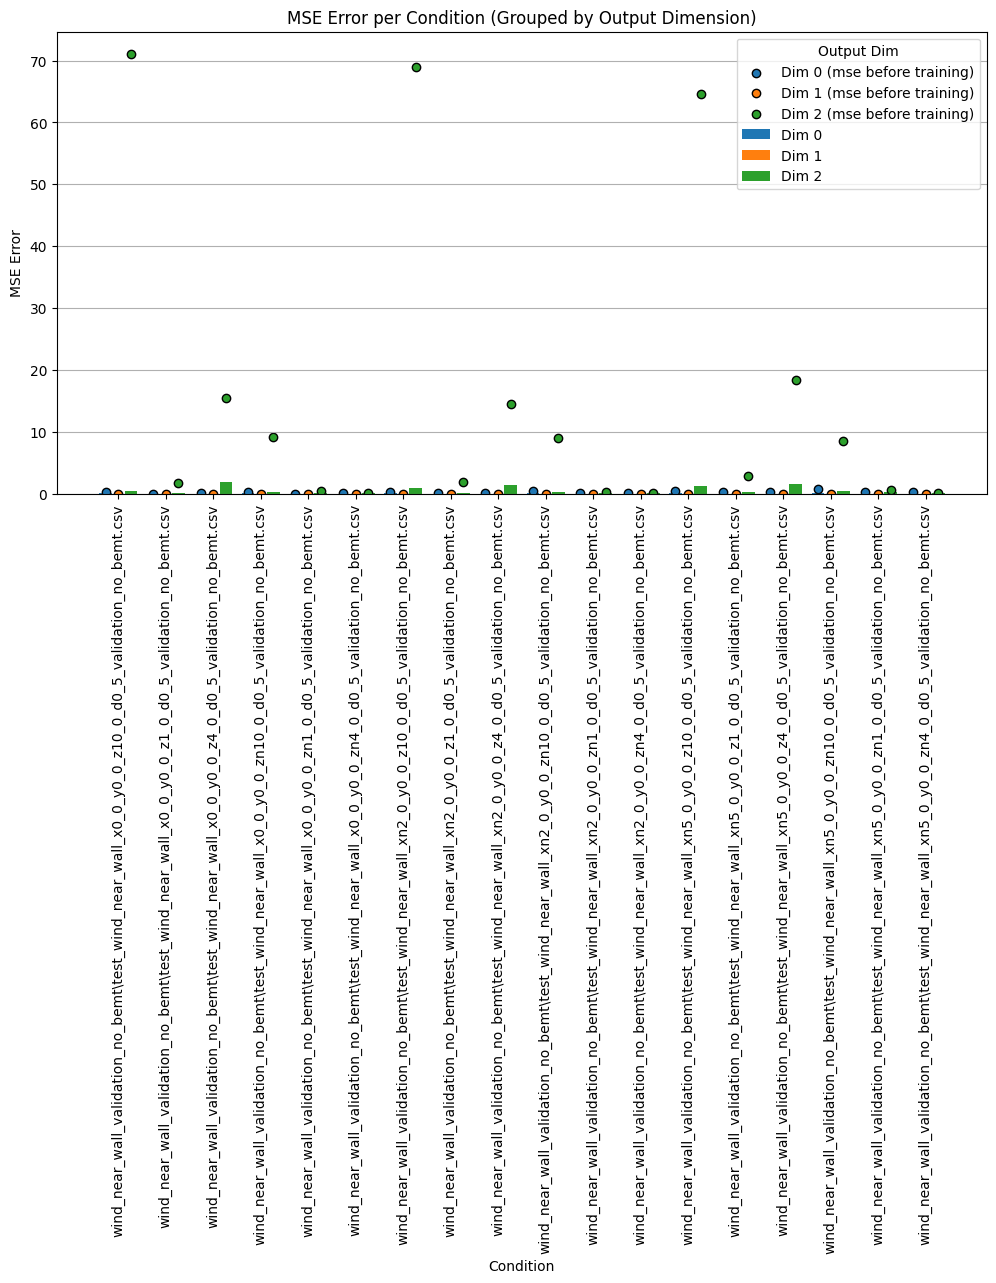

In [5]:
%matplotlib inline
model_name = training_subfolder

subfolder = validation_subfolder
subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
